## Heart Sound Classification with 2D-ResNet

In [1]:
# Import required libraries
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Configuration

In [3]:
# parameters
DATA_DIR = "data" 
CLASSES = ["abnormal", "artifact", "normal"]
SAMPLE_RATE = 22050
DURATION = 5  # seconds
N_MFCC = 64
INPUT_SHAPE = (128, 128, 1)  # Updated for 2D input
BATCH_SIZE = 32
EPOCHS = 50

### Audio Processing Functions

In [6]:
def process_audio(file_path):
    input_length = SAMPLE_RATE * DURATION
    
    # Load audio
    X, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    
    # Pad if shorter than duration
    if len(X) < input_length:
        pad_width = input_length - len(X)
        X = np.pad(X, (0, pad_width), mode='constant')
    
    # Extract MFCCs with temporal information
    mfccs = librosa.feature.mfcc(y=X, sr=sr, n_mfcc=N_MFCC, 
                                n_fft=2048, hop_length=512)
    
    # Normalize MFCCs
    mfccs = (mfccs - np.mean(mfccs)) / np.std(mfccs)
    
    return mfccs

# Data augmentation
def time_masking(mels, max_mask=10):
    num_steps = mels.shape[1]
    t = np.random.randint(0, max_mask)
    t0 = np.random.randint(0, num_steps - t)
    mels[:, t0:t0+t] = 0
    return mels

def frequency_masking(mels, max_mask=10):
    num_mels = mels.shape[0]
    f = np.random.randint(0, max_mask)
    f0 = np.random.randint(0, num_mels - f)
    mels[f0:f0+f, :] = 0
    return mels

### Data Loading

In [9]:
def load_dataset(data_dir):
    features = []
    labels = []
    
    for label_idx, class_name in enumerate(CLASSES):
        class_dir = os.path.join(data_dir, class_name)
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            
            # Process audio
            mfccs = process_audio(file_path)
            
            # Basic data augmentation
            mfccs_aug = time_masking(mfccs.copy())
            mfccs_aug = frequency_masking(mfccs_aug)
            
            # Resize to input shape (using interpolation)
            mfccs = tf.image.resize(mfccs[..., np.newaxis], INPUT_SHAPE[:2])
            mfccs_aug = tf.image.resize(mfccs_aug[..., np.newaxis], INPUT_SHAPE[:2])
            
            features.extend([mfccs, mfccs_aug])
            labels.extend([label_idx, label_idx])
    
    return np.array(features), tf.keras.utils.to_categorical(labels)

### 2D-ResNet Model Architecture

In [12]:
def residual_block(x, filters, kernel_size=3, dropout_rate=0.2, l2_weight=1e-4):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', 
                     kernel_regularizer=regularizers.l2(l2_weight))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Conv2D(filters, kernel_size, padding='same', 
                     kernel_regularizer=regularizers.l2(l2_weight))(x)
    x = layers.BatchNormalization()(x)
    
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding='same', 
                                kernel_regularizer=regularizers.l2(l2_weight))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

def build_2d_resnet(input_shape=INPUT_SHAPE, num_classes=3):
    inputs = layers.Input(shape=input_shape)
    
    # Initial layers
    x = layers.Conv2D(64, 7, strides=2, padding='same', 
                     kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, 64, dropout_rate=0.3)
    x = residual_block(x, 128, dropout_rate=0.3)
    x = residual_block(x, 256, dropout_rate=0.4)
    
    # Final layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', 
                    kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

### Training Setup

In [15]:
# Load and prepare data
print("Loading data...")
X, y = load_dataset(DATA_DIR)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

Loading data...


C:\Users\Lakindu\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Lakindu\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\Lakindu\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [16]:
# Build model
model = build_2d_resnet()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
             loss='categorical_crossentropy',
             metrics=['accuracy', 
                     tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 64, 64, 64)        │           3,200 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 64, 64, 64)        │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 64, 64, 64)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 32, 32, 64)        │               0 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 32, 32, 64)        │          36,928 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 32, 64)        │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 32, 32, 64)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 32, 32, 64)        │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 32, 32, 64)        │          36,928 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 32, 32, 64)        │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 32, 32, 64)        │               0 │ max_pooling2d[0][0],       │
│                               │                           │                 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 32, 32, 64)        │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 32, 32, 128)       │             512 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │               

 Total params: 1,297,027 (4.95 MB)

 Trainable params: 1,294,339 (4.94 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [19]:
# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model_0002.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

### Model Training

In [22]:
print("Starting training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Starting training...
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6024 - loss: 0.8769 - precision: 0.6561 - recall: 0.4576

113/113 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.6029 - loss: 0.8758 - precision: 0.6565 - recall: 0.4587 - val_accuracy: 0.3637 - val_loss: 1.6620 - val_precision: 0.3670 - val_recall: 0.3637 - learning_rate: 1.0000e-04
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.7512 - loss: 0.6101 - precision: 0.7633 - recall: 0.7354 - val_accuracy: 0.3726 - val_loss: 1.9612 - val_precision: 0.3735 - val_recall: 0.3726 - learning_rate: 1.0000e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7671 - loss: 0.5922 - precision: 0.7777 - recall: 0.7538

113/113 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.7671 - loss: 0.5921 - precision: 0.7777 - recall: 0.7539 - val_accuracy: 0.6440 - val_loss: 0.9032 - val_precision: 0.6531 - val_recall: 0.6263 - learning_rate: 1.0000e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.7752 - loss: 0.5756 - precision: 0.7811 - recall: 0.7675 - val_accuracy: 0.6073 - val_loss: 0.9201 - val_precision: 0.6247 - val_recall: 0.5962 - learning_rate: 1.0000e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7874 - loss: 0.5524 - precision: 0.7930 - recall: 0.7757

113/113 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.7873 - loss: 0.5526 - precision: 0.7929 - recall: 0.7757 - val_accuracy: 0.7820 - val_loss: 0.5778 - val_precision: 0.7848 - val_recall: 0.7786 - learning_rate: 1.0000e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.7859 - loss: 0.5599 - precision: 0.7906 - recall: 0.7751 - val_accuracy: 0.7175 - val_loss: 0.7139 - val_precision: 0.7241 - val_recall: 0.7152 - learning_rate: 1.0000e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.8130 - loss: 0.5278 - precision: 0.8165 - recall: 0.8045 - val_accuracy: 0.7697 - val_loss: 0.6111 - val_precision: 0.7716 - val_recall: 0.7664 - learning_rate: 1.0000e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.8186 - loss: 0.5051 - precision: 0.8221 - recall: 0.8118 - val_accuracy: 0.7553 - val_loss: 0.6354 - val_precision: 0.7590 - val_recall: 0.7464 - learning_rate: 1.0000e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - ac

113/113 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.8278 - loss: 0.4866 - precision: 0.8338 - recall: 0.8240 - val_accuracy: 0.8265 - val_loss: 0.4845 - val_precision: 0.8283 - val_recall: 0.8209 - learning_rate: 5.0000e-05
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.8423 - loss: 0.4731 - precision: 0.8450 - recall: 0.8365 - val_accuracy: 0.6919 - val_loss: 0.7236 - val_precision: 0.6951 - val_recall: 0.6897 - learning_rate: 5.0000e-05
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.8468 - loss: 0.4657 - precision: 0.8499 - recall: 0.8423 - val_accuracy: 0.8131 - val_loss: 0.4896 - val_precision: 0.8182 - val_recall: 0.8109 - learning_rate: 5.0000e-05
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8361 - loss: 0.4741 - precision: 0.8376 - recall: 0.8350

113/113 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.8362 - loss: 0.4740 - precision: 0.8376 - recall: 0.8350 - val_accuracy: 0.8331 - val_loss: 0.4635 - val_precision: 0.8350 - val_recall: 0.8331 - learning_rate: 5.0000e-05
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.8340 - loss: 0.4709 - precision: 0.8364 - recall: 0.8312 - val_accuracy: 0.7809 - val_loss: 0.5322 - val_precision: 0.7841 - val_recall: 0.7798 - learning_rate: 5.0000e-05
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.8434 - loss: 0.4531 - precision: 0.8441 - recall: 0.8391 - val_accuracy: 0.8420 - val_loss: 0.4744 - val_precision: 0.8430 - val_recall: 0.8420 - learning_rate: 5.0000e-05
Epoch 15/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.8421 - loss: 0.4561 - precision: 0.8430 - recall: 0.8388 - val_accuracy: 0.8343 - val_loss: 0.4710 - val_precision: 0.8359 - val_recall: 0.8331 - learning_rate: 5.0000e-05
Epoch 16/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step 

113/113 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.8469 - loss: 0.4401 - precision: 0.8480 - recall: 0.8441 - val_accuracy: 0.8387 - val_loss: 0.4550 - val_precision: 0.8393 - val_recall: 0.8365 - learning_rate: 2.5000e-05
Epoch 17/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.8597 - loss: 0.4284 - precision: 0.8609 - recall: 0.8580 - val_accuracy: 0.8209 - val_loss: 0.5052 - val_precision: 0.8221 - val_recall: 0.8176 - learning_rate: 2.5000e-05
Epoch 18/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.8559 - loss: 0.4313 - precision: 0.8576 - recall: 0.8542 - val_accuracy: 0.8376 - val_loss: 0.4563 - val_precision: 0.8380 - val_recall: 0.8343 - learning_rate: 2.5000e-05
Epoch 19/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.8515 - loss: 0.4353 - precision: 0.8530 - recall: 0.8498 - val_accuracy: 0.8287 - val_loss: 0.4797 - val_precision: 0.8294 - val_recall: 0.8276 - learning_rate: 2.5000e-05
Epoch 20/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step 

113/113 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.8578 - loss: 0.4260 - precision: 0.8591 - recall: 0.8566 - val_accuracy: 0.8454 - val_loss: 0.4423 - val_precision: 0.8462 - val_recall: 0.8443 - learning_rate: 1.2500e-05
Epoch 21/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8721 - loss: 0.4007 - precision: 0.8729 - recall: 0.8693

113/113 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.8720 - loss: 0.4008 - precision: 0.8729 - recall: 0.8693 - val_accuracy: 0.8565 - val_loss: 0.4339 - val_precision: 0.8571 - val_recall: 0.8543 - learning_rate: 1.2500e-05
Epoch 22/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8625 - loss: 0.4140 - precision: 0.8633 - recall: 0.8603

113/113 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.8625 - loss: 0.4140 - precision: 0.8633 - recall: 0.8604 - val_accuracy: 0.8509 - val_loss: 0.4307 - val_precision: 0.8525 - val_recall: 0.8487 - learning_rate: 1.2500e-05
Epoch 23/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.8563 - loss: 0.4254 - precision: 0.8561 - recall: 0.8547 - val_accuracy: 0.8632 - val_loss: 0.4322 - val_precision: 0.8641 - val_recall: 0.8632 - learning_rate: 1.2500e-05
Epoch 24/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.8665 - loss: 0.4157 - precision: 0.8671 - recall: 0.8653 - val_accuracy: 0.8165 - val_loss: 0.4928 - val_precision: 0.8168 - val_recall: 0.8131 - learning_rate: 1.2500e-05
Epoch 25/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.8699 - loss: 0.4117 - precision: 0.8710 - recall: 0.8689 - val_accuracy: 0.8498 - val_loss: 0.4368 - val_precision: 0.8517 - val_recall: 0.8498 - learning_rate: 1.2500e-05
Epoch 26/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 841s 7s/ste

113/113 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.8787 - loss: 0.4005 - precision: 0.8794 - recall: 0.8779 - val_accuracy: 0.8554 - val_loss: 0.4295 - val_precision: 0.8551 - val_recall: 0.8532 - learning_rate: 6.2500e-06
Epoch 28/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.8681 - loss: 0.4068 - precision: 0.8702 - recall: 0.8672 - val_accuracy: 0.8543 - val_loss: 0.4333 - val_precision: 0.8549 - val_recall: 0.8521 - learning_rate: 6.2500e-06
Epoch 29/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 841s 7s/step - accuracy: 0.8720 - loss: 0.4107 - precision: 0.8732 - recall: 0.8683 - val_accuracy: 0.8487 - val_loss: 0.4481 - val_precision: 0.8495 - val_recall: 0.8476 - learning_rate: 6.2500e-06
Epoch 30/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.8837 - loss: 0.3997 - precision: 0.8841 - recall: 0.8821 - val_accuracy: 0.8532 - val_loss: 0.4416 - val_precision: 0.8528 - val_recall: 0.8509 - learning_rate: 6.2500e-06
Epoch 31/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/ste

113/113 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.8801 - loss: 0.3894 - precision: 0.8806 - recall: 0.8777 - val_accuracy: 0.8576 - val_loss: 0.4267 - val_precision: 0.8586 - val_recall: 0.8576 - learning_rate: 3.1250e-06
Epoch 33/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.8760 - loss: 0.4002 - precision: 0.8769 - recall: 0.8740 - val_accuracy: 0.8532 - val_loss: 0.4374 - val_precision: 0.8536 - val_recall: 0.8498 - learning_rate: 3.1250e-06
Epoch 34/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.8870 - loss: 0.3812 - precision: 0.8876 - recall: 0.8857 - val_accuracy: 0.8587 - val_loss: 0.4282 - val_precision: 0.8597 - val_recall: 0.8587 - learning_rate: 3.1250e-06
Epoch 35/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.8851 - loss: 0.3839 - precision: 0.8853 - recall: 0.8848 - val_accuracy: 0.8543 - val_loss: 0.4389 - val_precision: 0.8538 - val_recall: 0.8509 - learning_rate: 3.1250e-06
Epoch 36/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/ste

### Training Visualization

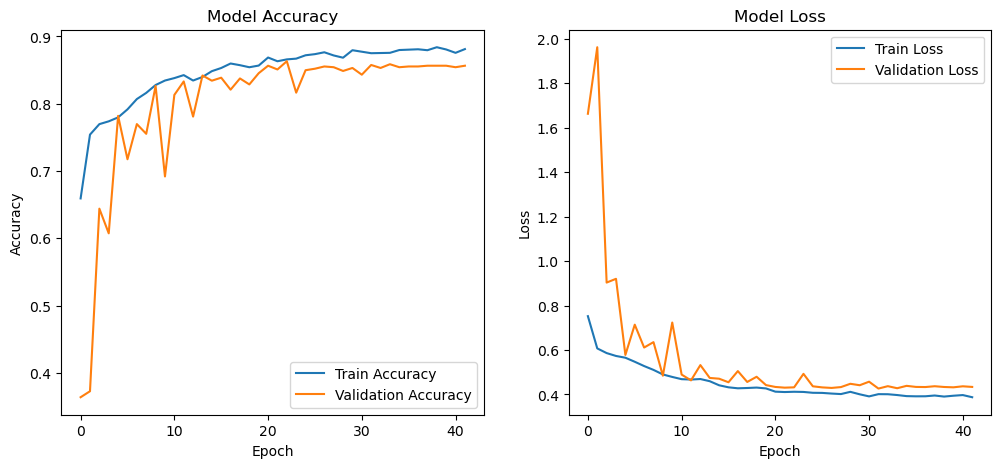

In [32]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Model Testing (Example)

In [34]:
def test_prediction(file_path):
    mfccs = process_audio(file_path)
    mfccs = tf.image.resize(mfccs[..., np.newaxis], INPUT_SHAPE[:2])
    prediction = model.predict(np.expand_dims(mfccs, 0))
    return {CLASSES[i]: float(prediction[0][i]) for i in range(len(CLASSES))}

# Example usage
test_file = "test_data/123.wav"
print("Test prediction:", test_prediction(test_file))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
Test prediction: {'abnormal': 0.18677736818790436, 'artifact': 7.907983672339469e-05, 'normal': 0.8131434917449951}


In [36]:
def evaluate_model(model, x_test, y_test, class_names):
    y_pred_probs = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Classification report
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred_classes, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Print raw matrix
    print("Confusion Matrix (Raw Counts):\n", cm)
    print("Confusion Matrix (Normalized):\n", np.round(cm_normalized, 2))

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title('Confusion Matrix (Raw Counts)')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title('Confusion Matrix (Normalized)')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.savefig("confusion_matrices.png", dpi=300)
    plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 352ms/step
Classification Report:

              precision    recall  f1-score   support

    abnormal       0.87      0.72      0.79       327
    artifact       1.00      1.00      1.00       245
      normal       0.76      0.89      0.82       327

    accuracy                           0.86       899
   macro avg       0.87      0.87      0.87       899
weighted avg       0.86      0.86      0.86       899

Confusion Matrix (Raw Counts):
 [[236   0  91]
 [  0 245   0]
 [ 36   1 290]]
Confusion Matrix (Normalized):
 [[0.72 0.   0.28]
 [0.   1.   0.  ]
 [0.11 0.   0.89]]


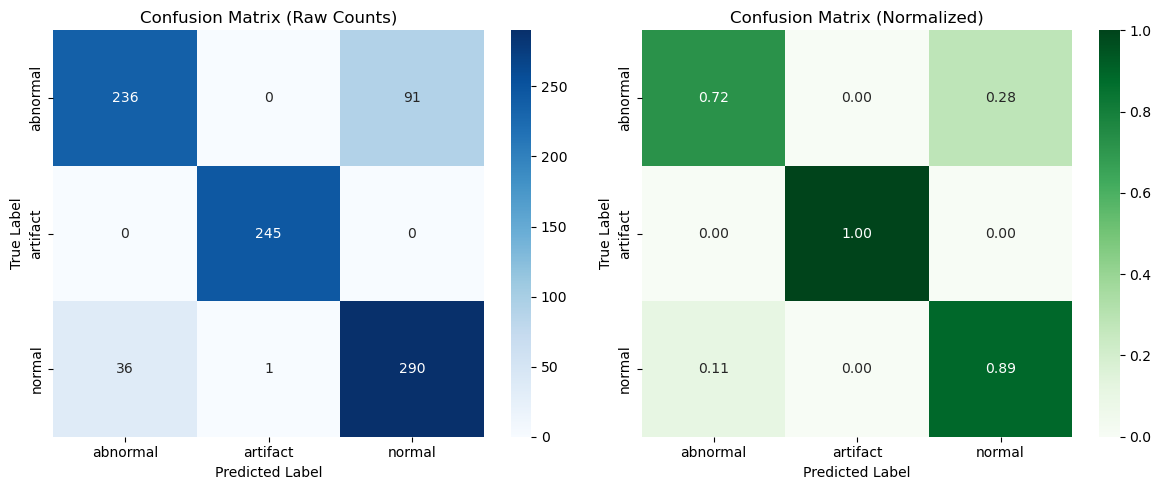

In [38]:
class_names = ['abnormal', 'artifact', 'normal']
# evaluate_model(model, X_val, y_val, class_names)
evaluate_model(model, X_val, np.argmax(y_val, axis=1), class_names)


In [ ]:
# as a keras model
model.save('models/heart_sound_model1_v5_0002.keras')
# as a h5 model
model.save("models/heart_sound_model1_v5_0002.h5")